
# Data Engineering Capstone Project

#### Project Summary
For the project we are going to assume we are an Intelligene Company inside the airline industry, and we are creating a new product called 'Travel Intelligence' that sells data to Airports & Airlines.

We will be cleaning the provided datasets and creating an star-scheme table where clients can purchase the fact table, and separately the dimension tables.




The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
!pip install reverse_geocoder

import pandas as pd
import seaborn as sns
import numpy as np
import datetime 
import re
from pyspark.sql.functions import col, create_map, lit, to_date, countDistinct, year, month, expr, mean, udf , to_timestamp
from itertools import chain
import reverse_geocoder
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType

pd.set_option('max_columns', None)

spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 

The plan for the project is to create a fact and dimension tables, where the fact table is the immigration data without aggregation, , and the dimensions tables are other referential datasets, such as temperature, city information, demographics, etc. 

What I plan to do in the project is clean the data, making sure the joining columns are all in a similar format, and also ensuring that its easirt to add more referential data to complement the fact table.

The tech stack is going to be simple: Pandas for small datasets, Pyspark for large ones. This is for the development of the ETL, if we were going to industralize it, we would use Airflow, everything in Spark for scalability purposes.

The data will be described below.

#### Describe and Gather Data 

In [2]:
# Read in the data here
df_airport_codes= pd.read_csv('raw/airport-codes_csv.csv')
df_immigratio_sample = pd.read_csv('raw/immigration_data_sample.csv')
df_cities = pd.read_csv('raw/us-cities-demographics.csv', sep = ';')
df_temperatures = pd.read_csv('raw/GlobalLandTemperaturesByCity.csv', parse_dates = ['dt'])

##### <font color='blue'>IMMIGRATION</font> 

International visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries).

source: https://travel.trade.gov/research/reports/i94/historical/2016.html
```
"Unnamed: 0" -> 
"cicid"      -> Traveller CiC id
"i94yr"      -> Departure year
"i94mon"     -> Departure month
"i94cit"     -> Departure City 
"i94res"     -> Unknown
"i94port"    -> Arrival port
"arrdate"    -> Arrival date 
"i94mode"    -> How the traveller arrived to USA 
"i94addr"    -> Address in the US Arrival/Departure - unknown
"depdate"    -> Departure Date from the USA - in x time
"i94bir"     -> Age of Respondent in Years
"i94visa"    -> Visa codes collapsed into three categories
"count"      -> Used for summary statistics
"dtadfile"   -> Character Date Field - Date added to I-94 Files 
"visapost"   -> Department of State where where Visa was issued 
"occup"      -> Occupation that will be performed in U.S.
"entdepa"    -> Arrival Flag - admitted or paroled into the U.S. - CIC does not use
"entdepd"    -> Departure Flag - Departed, lost I-94 or is deceased
"entdepu"    -> Update Flag - Either apprehended, overstayed, adjusted to perm residence - CIC does not use
"matflag"    -> Match of arrival and departure records
"biryear"    -> Traveller - Year of birth
"dtaddto"    -> Visa - Date to which admmitted to US
"gender"     -> Traveller - Gender
"insnum"     -> INS number
"airline"    -> Arrival Airline IATA code
"admnum"     -> Visa Admission Number
"fltno"      -> Arrival Flight Number
"visatype"   -> Traveller - type of visa
```

In [3]:
df_immigratio_sample.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,20573.0,61.0,2.0,1.0,20160422,NaN,NaN,G,O,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,20568.0,26.0,2.0,1.0,20160423,MTR,NaN,G,R,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,20571.0,76.0,2.0,1.0,20160407,NaN,NaN,G,O,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,20581.0,25.0,2.0,1.0,20160428,DOH,NaN,G,O,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,20553.0,19.0,2.0,1.0,20160406,NaN,NaN,Z,K,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


##### <font color='blue'>AIRPORT CODES</font> 

Contains the list of all airport codes. Some of the columns contain attributes identifying airport locations, other codes (IATA, local if exist) that are relevant to identification of an airport.

Source: https://datahub.io/core/airport-codes#data

In [4]:
df_airport_codes.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


##### <font color='blue'>TEMPERATURES</font> 

Temperature data for cities around the globe. 

Soruce: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [5]:
df_temperatures.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


##### <font color='blue'>CITIES</font> 

This dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. 

This data comes from the US Census Bureau's 2015 American Community Survey.

Source: https://public.opendatasoft.com/explore/dataset/us-cities-demographics/table/

In [6]:
df_cities.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [7]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}


Cities looks very clean.

In [8]:
df_spark =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

In [9]:
#write to parquet
df_spark.write.mode('overwrite').parquet("sas_data")
df_spark_immigration=spark.read.parquet("sas_data")

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

##### <font color='blue'>AIRPORT CODES</font> 


(55075, 12)


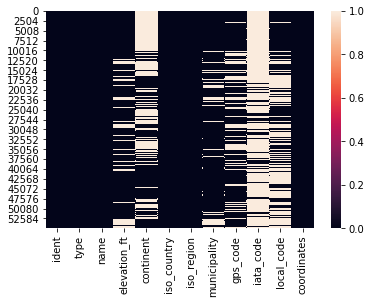

In [10]:
print(df_airport_codes.shape)
sns.heatmap(df_airport_codes.isnull())


In [11]:
df_airport_codes.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55075 entries, 0 to 55074
Data columns (total 12 columns):
ident           55075 non-null object
type            55075 non-null object
name            55075 non-null object
elevation_ft    48069 non-null float64
continent       27356 non-null object
iso_country     54828 non-null object
iso_region      55075 non-null object
municipality    49399 non-null object
gps_code        41030 non-null object
iata_code       9189 non-null object
local_code      28686 non-null object
coordinates     55075 non-null object
dtypes: float64(1), object(11)
memory usage: 5.0+ MB


In [12]:
# Checking for duplicated id's
df_airport_codes['ident'].value_counts(ascending = False).head()

3NY7    1
FASH    1
CAH8    1
61IS    1
IA87    1
Name: ident, dtype: int64

It seems all of the ids are unique. That is very good :) 

Lets now check airport names are also unique:

In [13]:

df_airport_codes['name'].value_counts(ascending = False).head()


Centre Hospitalier Heliport    85
Mukho Port Heliport            50
Hospital Heliport              19
Memorial Hospital Heliport     18
Cheonmi-ri South Heliport      16
Name: name, dtype: int64

It seems they are not unique, lets have a deeper look to see if, there are N airports in different places sharing the same names, or N ids pointing at the same airport:

In [14]:
centre_hospitalier = df_airport_codes[df_airport_codes['name'] == 'Centre Hospitalier Heliport']
centre_hospitalier['municipality'].value_counts(ascending = False).head()

Saint-Omer      1
Saint-Dizier    1
Bourges         1
Niort           1
Soissons        1
Name: municipality, dtype: int64

In [15]:
mukho = df_airport_codes[df_airport_codes['name'] == 'Mukho Port Heliport']
mukho['municipality'].value_counts(ascending = False).head()

Mukho    50
Name: municipality, dtype: int64

In [16]:
mukho.sample(5)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
28960,KR-0276,heliport,Mukho Port Heliport,NaN,AS,KR,KR-42,Mukho,NaN,NaN,NaN,"129.115255, 37.540345"
28933,KR-0249,heliport,Mukho Port Heliport,NaN,AS,KR,KR-42,Mukho,NaN,NaN,NaN,"129.115255, 37.540345"
28921,KR-0237,heliport,Mukho Port Heliport,NaN,AS,KR,KR-42,Mukho,NaN,NaN,NaN,"129.115255, 37.540345"
28928,KR-0244,heliport,Mukho Port Heliport,NaN,AS,KR,KR-42,Mukho,NaN,NaN,NaN,"129.115255, 37.540345"
28929,KR-0245,heliport,Mukho Port Heliport,NaN,AS,KR,KR-42,Mukho,NaN,NaN,NaN,"129.115255, 37.540345"


In [17]:
df_airport_codes[df_airport_codes['iso_region'] == 'KR-42'].sample(3)


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
28917,KR-0233,heliport,Ssangyong East Cement Plant Heliport,NaN,AS,KR,KR-42,Iro-dong (Donghae),NaN,NaN,NaN,"129.064352, 37.487569"
28853,KR-0169,heliport,Sangwon-ri Helipad,NaN,AS,KR,KR-42,Sangwon-ri,NaN,NaN,NaN,"128.30156, 38.40695"
29188,KR-0504,heliport,Cheonmi-ri South Heliport,NaN,AS,KR,KR-42,Cheonmi-ri,NaN,NaN,NaN,"127.871211, 38.247439"


Interesting, actually both things are happening.

Lets now check the iata_codes. We saw before that it has a lot of nulls, lets have a deeper look:

In [18]:
(df_airport_codes['iata_code'].isnull().sum() / df_airport_codes.shape[0]) * 100

83.315478892419421

This is not good news, 83% of the iata_codes are empty. This will complicate joining with other datasets.

Lets see if the issue is happening to the other codes:

In [19]:
gps_code = (df_airport_codes['gps_code'].isnull().sum() / df_airport_codes.shape[0]) * 100
local_code = (df_airport_codes['local_code'].isnull().sum() / df_airport_codes.shape[0]) * 100

print('gps_code: ',gps_code)
print('local_code: ',local_code)

gps_code:  25.5015887426
local_code:  47.9146618248


<span style="color:DarkRed">

Findings:
- Missing Continent data
- One Airport can have multiple ID's 
- Multiple airports can share the same name, but not the ID (its unique)
- (!) 83% of iata codes are empty, we may have to join by name and/or coordinates and/or location - if local & gps code are not useful.
- Airport data could be complimented with external source
    
</span>

##### <font color='blue'>TEMPERATURES</font> 

In [20]:
df_temperatures.sample(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
865264,1873-02-01,0.747,1.239,Besançon,France,47.42N,5.92E
5486875,1999-08-01,17.650,0.179,Orël,Russia,52.24N,36.79E
5080553,1826-06-01,17.507,2.579,Namur,Belgium,50.63N,3.80E
3718409,1920-06-01,16.756,0.416,Kayseri,Turkey,39.38N,35.38E
3196855,1993-04-01,28.238,0.102,Inisa,Nigeria,7.23N,4.05E


In [21]:
df_temperatures.shape

(8599212, 7)

That is a lot of rows, lets understand why by checking the range of dates:

In [22]:
print(df_temperatures['dt'].max())
print(df_temperatures['dt'].min())

2013-09-01 00:00:00
1743-11-01 00:00:00


Interesting finding, the daterange does not cover the immigration data range. Something should be done about it, lets take note for now!

In [23]:
df_temperatures.sample(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
307425,2010-07-01,23.866,0.183,Angren,Uzbekistan,40.99N,70.30E
1255016,1852-10-01,20.162,1.413,Cúcuta,Colombia,7.23N,72.16W
4053670,1935-07-01,16.738,0.221,Kursk,Russia,52.24N,36.79E
6466120,1862-06-01,17.625,1.785,São Carlos,Brazil,21.70S,47.60W
3321050,1947-09-01,24.052,0.246,Jaboatão,Brazil,8.84S,34.86W


Lets check for duplicated data:

In [24]:
df_temperatures[['dt','City','Country']].duplicated().sum()

46034

It seems that at date-city-country there are duplicates, this may occure because one city could have multiple stations. Lets include latitude and longitede and see if there are duplicates:

In [25]:
df_temperatures[['dt','City','Country','Latitude','Longitude']].duplicated().sum()

0

Great! there are no duplicates.

Lets now inspect if there are data quality issues nulls:

In [26]:
df_temperatures.isnull().sum() / df_temperatures.count() * 100

dt                               0.000000
AverageTemperature               4.421692
AverageTemperatureUncertainty    4.421692
City                             0.000000
Country                          0.000000
Latitude                         0.000000
Longitude                        0.000000
dtype: float64

It seems that we have some null values in the key column: AverageTemperature    

<span style="color:DarkRed">

Findings
- (!) There is no data for 2016! -> Solution below.
- Coordinates are in different format; compared to airports.
- df_airport_codes.Municipality == df_temperatures.city?
- Data should be provided at airport level.
- Nulls in key column: AverageTemperature
    
    </span>
    
(!) Interesting, the provided dataset doesnt have data for 2016. Its a great dataset for historical data, however it is not very helful for the kind of data we are providing for our clients.

There a few few things we can do:
a. Not use tempereture data.
b. Look for another data-feed.

Lets assume that option A is not possible, because we have already agreed with a client to have the data.
B is probably the the best option; however I have spent some time looking around and I couldnt find a suitable data-source. **Hence we are going to opt for option C.**

And... option C consist in assuming that we are a real company; the reason we dont have up-to-date data is because there has been a server failure, and the DevOps are working on retreiving the lost data from the Archive; in the meantime, since we are developing the ETL, and not working on the insights, we are going to continue using this dataset. As soon as the correct data is available, we would only need to updated the path.


##### <font color='blue'>CITIES</font> 


(2891, 12)


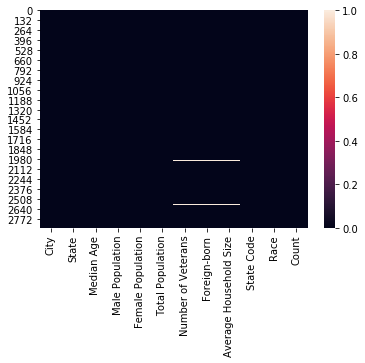

In [27]:
print(df_cities.shape)
sns.heatmap(df_cities.isnull())

In [28]:
df_cities[df_cities['Foreign-born'].isnull()]

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
111,San Juan,Puerto Rico,41.4,155408.0,186829.0,342237,NaN,NaN,NaN,PR,Hispanic or Latino,335559
155,Caguas,Puerto Rico,40.4,34743.0,42265.0,77008,NaN,NaN,NaN,PR,Hispanic or Latino,76349
258,Carolina,Puerto Rico,42.0,64758.0,77308.0,142066,NaN,NaN,NaN,PR,American Indian and Alaska Native,12143
637,Carolina,Puerto Rico,42.0,64758.0,77308.0,142066,NaN,NaN,NaN,PR,Hispanic or Latino,139967
1747,San Juan,Puerto Rico,41.4,155408.0,186829.0,342237,NaN,NaN,NaN,PR,American Indian and Alaska Native,4031
1748,Mayagüez,Puerto Rico,38.1,30799.0,35782.0,66581,NaN,NaN,NaN,PR,Asian,235
1995,Ponce,Puerto Rico,40.5,56968.0,64615.0,121583,NaN,NaN,NaN,PR,Hispanic or Latino,120705
2004,Bayamón,Puerto Rico,39.4,80128.0,90131.0,170259,NaN,NaN,NaN,PR,Hispanic or Latino,169155
2441,San Juan,Puerto Rico,41.4,155408.0,186829.0,342237,NaN,NaN,NaN,PR,Asian,2452
2589,Guaynabo,Puerto Rico,42.2,33066.0,37426.0,70492,NaN,NaN,NaN,PR,Hispanic or Latino,69936


There are some nulls on non-key columns, hence we will keep the dataset as it is.

In [29]:
df_cities.sample(5)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
384,Arvada,Colorado,41.0,54870.0,60165.0,115035,8930.0,4921.0,2.49,CO,Hispanic or Latino,16419
366,Kansas City,Missouri,35.9,228430.0,246931.0,475361,24710.0,37787.0,2.35,MO,Hispanic or Latino,46037
2127,Jacksonville,Florida,35.7,419203.0,448828.0,868031,75432.0,85650.0,2.62,FL,Asian,50895
1782,O'Fallon,Missouri,36.0,41762.0,43270.0,85032,5783.0,3269.0,2.77,MO,Asian,3447
1522,Joliet,Illinois,33.1,70863.0,79162.0,150025,7353.0,22409.0,3.13,IL,White,106160


In [30]:
df_cities[['City','State']].duplicated().sum()

2295

That seems to be a lot of duplicates

In [31]:
df_cities[df_cities[['City','State']].duplicated()].sort_values(['State','City']).head(10)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
1063,Birmingham,Alabama,35.6,102122.0,112789.0,214911,13212.0,8258.0,2.21,AL,American Indian and Alaska Native,1319
2025,Birmingham,Alabama,35.6,102122.0,112789.0,214911,13212.0,8258.0,2.21,AL,White,51728
2231,Birmingham,Alabama,35.6,102122.0,112789.0,214911,13212.0,8258.0,2.21,AL,Black or African-American,157985
2627,Birmingham,Alabama,35.6,102122.0,112789.0,214911,13212.0,8258.0,2.21,AL,Hispanic or Latino,8940
500,Dothan,Alabama,38.9,32172.0,35364.0,67536,6334.0,1699.0,2.59,AL,Hispanic or Latino,1704
1064,Dothan,Alabama,38.9,32172.0,35364.0,67536,6334.0,1699.0,2.59,AL,Black or African-American,23243
1580,Dothan,Alabama,38.9,32172.0,35364.0,67536,6334.0,1699.0,2.59,AL,White,43516
1925,Dothan,Alabama,38.9,32172.0,35364.0,67536,6334.0,1699.0,2.59,AL,American Indian and Alaska Native,656
960,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Black or African-American,18191
1410,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Hispanic or Latino,3430


Ok, it seems that the aggregation level of the dataset ios City, State and Race. Good information.

<span style="color:DarkRed">

Findings
- The dataset seems that has already been processed and it can be of use.
- The main issue is that we dont have coordenates, this may be an issue for joining with other datasets. We may need to enrich it
    
    </span>


##### <font color='blue'>IMMIGRATION</font> 


First, lets check for duplicated rows, taking into account all columns:

In [32]:
df_spark_immigration.dropDuplicates().count()-df_spark_immigration.count()

0

Great starting point, no duplicates taking into account all the columns. Lets check for nulls:

In [33]:
def count_null (df, columns):
    total = df.count()
    for c in columns:
        null_count = df.filter(f'{c} is null').count()
        print(c, " -> ", null_count, " : " , round((null_count/total)*100, 3), '%')

In [34]:
count_null(df_spark_immigration,df_spark_immigration.columns )

cicid  ->  0  :  0.0 %
i94yr  ->  0  :  0.0 %
i94mon  ->  0  :  0.0 %
i94cit  ->  0  :  0.0 %
i94res  ->  0  :  0.0 %
i94port  ->  0  :  0.0 %
arrdate  ->  0  :  0.0 %
i94mode  ->  239  :  0.008 %
i94addr  ->  152592  :  4.928 %
depdate  ->  142457  :  4.601 %
i94bir  ->  802  :  0.026 %
i94visa  ->  0  :  0.0 %
count  ->  0  :  0.0 %
dtadfile  ->  1  :  0.0 %
visapost  ->  1881250  :  60.758 %
occup  ->  3088187  :  99.738 %
entdepa  ->  238  :  0.008 %
entdepd  ->  138429  :  4.471 %
entdepu  ->  3095921  :  99.987 %
matflag  ->  138429  :  4.471 %
biryear  ->  802  :  0.026 %
dtaddto  ->  477  :  0.015 %
gender  ->  414269  :  13.379 %
insnum  ->  2982605  :  96.328 %
airline  ->  83627  :  2.701 %
admnum  ->  0  :  0.0 %
fltno  ->  19549  :  0.631 %
visatype  ->  0  :  0.0 %


Some clolumsn need to be further inspected, since they have a significant amount of nulls: visapost, occup, entdepu, insnum. 

Lets check the data quality:

In [35]:
df_spark_immigration.sample(False, 0.5, seed=0).show()

+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|    cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|        admnum|fltno|visatype|
+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|5748518.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     NV|20591.0|  32.0|    1.0|  1.0|20160430|     SYD| null|      G|      O|   null|      M| 1984.0|10292016|     F|  null|     VA|9.495562283E10|00007|      B1|
|5748525.0|2016.0|   4.0| 245.0| 464.0|    HOU|20574.0|    1.0|     FL|20581.0|  27.0|    2.0|  

In [36]:
df_spark_immigration.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

<span style="color:DarkRed">

Findings
- Data types will need to be corrected
- Dates need to be parsed to int or date: ['i94yr','i94mon','arrdate','depdate','dtadfile','biryear','dtaddto']
- Columns ['occup','insnum', 'entdepu'] dont hold information
    
    </span>


# Performing cleaning tasks here





#### Cleaning Steps

##### <font color='blue'>IMMIGRATION</font> 

In [37]:
df_spark_immigration = df_spark_immigration.drop('occup').drop('insnum').drop('entdepu')

Lets do a fast correction of types:

In [38]:
df_spark_immigration = df_spark_immigration\
        .withColumn("i94yr", df_spark_immigration["i94yr"].cast(IntegerType()))\
        .withColumn("i94mon", df_spark_immigration["i94mon"].cast(IntegerType()))\
        .withColumn("i94cit", df_spark_immigration["i94cit"].cast(IntegerType()))\
        .withColumn("i94res", df_spark_immigration["i94res"].cast(IntegerType()))\
        .withColumn("dtaddto", df_spark_immigration["dtaddto"].cast(IntegerType()))\
        .withColumn("cicid", df_spark_immigration["cicid"].cast(IntegerType()))\
        .withColumn("depdate", df_spark_immigration["depdate"].cast(IntegerType()))\
        .withColumn("i94mode", df_spark_immigration["i94mode"].cast(IntegerType()))\
        .withColumn("i94bir", df_spark_immigration["i94bir"].cast(IntegerType()))\
        .withColumn("i94visa", df_spark_immigration["i94visa"].cast(IntegerType()))\
        .withColumn("count", df_spark_immigration["count"].cast(IntegerType()))\
        .withColumn("biryear", df_spark_immigration["biryear"].cast(IntegerType()))

Lets first fix the dates: i94yr, i94mon, arrdate, depdate, dtadfile, biryear, dtaddto

In [39]:
df_spark_immigration.select(['i94yr','i94mon','arrdate','depdate','dtadfile','biryear','dtaddto']).printSchema()

root
 |-- i94yr: integer (nullable = true)
 |-- i94mon: integer (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- depdate: integer (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- biryear: integer (nullable = true)
 |-- dtaddto: integer (nullable = true)



Checking and treating nulls before casting to date types:

In [40]:
count_null(df_spark_immigration,['i94yr','i94mon','arrdate','depdate','dtadfile','biryear','dtaddto'])

i94yr  ->  0  :  0.0 %
i94mon  ->  0  :  0.0 %
arrdate  ->  0  :  0.0 %
depdate  ->  142457  :  4.601 %
dtadfile  ->  1  :  0.0 %
biryear  ->  802  :  0.026 %
dtaddto  ->  45823  :  1.48 %


Replace nulls and check again:

In [41]:
df_spark_immigration = df_spark_immigration.fillna(0, subset=['i94yr','i94mon','arrdate','depdate','dtadfile','biryear','dtaddto'])

In [42]:
count_null(df_spark_immigration,['i94yr','i94mon','arrdate','depdate','dtadfile','biryear','dtaddto'])

i94yr  ->  0  :  0.0 %
i94mon  ->  0  :  0.0 %
arrdate  ->  0  :  0.0 %
depdate  ->  0  :  0.0 %
dtadfile  ->  1  :  0.0 %
biryear  ->  0  :  0.0 %
dtaddto  ->  0  :  0.0 %


In [43]:
df_spark_immigration.show(5)

+-------+-----+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-------+-------+-------+-------+--------+------+-------+--------------+-----+--------+
|  cicid|i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|entdepa|entdepd|matflag|biryear| dtaddto|gender|airline|        admnum|fltno|visatype|
+-------+-----+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-------+-------+-------+-------+--------+------+-------+--------------+-----+--------+
|5748517| 2016|     4|   245|   438|    LOS|20574.0|      1|     CA|  20582|    40|      1|    1|20160430|     SYD|      G|      O|      M|   1976|10292016|     F|     QF|9.495387003E10|00011|      B1|
|5748518| 2016|     4|   245|   438|    LOS|20574.0|      1|     NV|  20591|    32|      1|    1|20160430|     SYD|      G|      O|      M|   1984|10292016|     F|     VA|9.495562283E10|00007|

Great, now its time to parse the dates-columns to date-types:

In [44]:
def parse_sas_date (sasdate):  
    epoch = datetime.datetime(1960, 1, 1)
    d = epoch + datetime.timedelta(days=sasdate)
    return str(d.date())

parse_sas_date_UDF = udf(lambda z: parse_sas_date(z),StringType())

def dtaddto_parser(text):
    text = str(text)
    try:
        return str(datetime.datetime.strptime(text, "%m%d%Y").date())
    except:
        return str(datetime.date(year = 1800, month = 1, day = 1))
    
dtaddto_parser_UDF = udf(lambda z: dtaddto_parser(z),StringType())

df_spark_immigration = df_spark_immigration\
        .withColumn('arrdate',to_date(parse_sas_date_UDF("arrdate"),'yyyy-MM-dd'))\
        .withColumn('depdate',to_date(parse_sas_date_UDF("depdate"), 'yyyy-MM-dd'))\
        .withColumn('dtadfile', to_date(df_spark_immigration.dtadfile, 'yyyyMMdd'))\
        .withColumn('dtaddto',to_date(dtaddto_parser_UDF("dtaddto"), 'yyyy-MM-dd'))

In [ ]:
df_spark_immigration.select(['i94yr','i94mon','arrdate','depdate','dtadfile','biryear','dtaddto']).show(5)

In [ ]:
df_spark_immigration.printSchema()

This looks much better :)

But lets complete the table with the code definitions from I94_SAS_Labels_Descriptions.SAS

In [ ]:
f_sas_dict = open("raw/I94_SAS_Labels_Descriptions.SAS")
f_sas_dict.readlines()[0:15]

This is going to need some serious parsing

There are four types of codes: three digit numeric, one digit numeric, three char  and two char, which means the code of one column is not going to impact the code of another column, except for 1 digit codes. This ones will be treated separetly.

Lets create a big dictionary of codes and apply it to the relevant columns (which are: I94CIT & I94RES, I94PORT, I94ADDR)

In [ ]:
mapping = {}

f_sas_dict = open("raw/I94_SAS_Labels_Descriptions.SAS")
for l in f_sas_dict:
    if '=' in l:
        k,v = l.split('=')
        mapping[k.replace("'","").strip()] = v.replace("'","").strip()

In [ ]:

mapping_expr = create_map([lit(x) for x in chain(*mapping.items())])

for c in ['I94CIT','I94RES', 'I94PORT', 'I94ADDR']:
    df_spark_immigration = df_spark_immigration.withColumn(c + '_dec', mapping_expr.getItem(col(c)))


Treating columns with one digit code:

i94model - 
	1 = 'Air'
	2 = 'Sea'
	3 = 'Land'
	9 = 'Not reported' ;
    
    
I94VISA - 
   1 = Business
   2 = Pleasure
   3 = Student

In [ ]:
dict_i94mode = {1:'Air', 2:'Sea', 3:'Land', 9 :'Not reported'}
dict_i94visa = {1:'Business',2:'Pleasure',3:'Student'}

In [ ]:
# map i94visa
mapping_expr_i94visa = create_map([lit(x) for x in chain(*dict_i94visa.items())])
df_spark_immigration = df_spark_immigration.withColumn('i94visa', mapping_expr_i94visa.getItem(col('i94visa')))

# map i94mode
mapping_expr_i94mode = create_map([lit(x) for x in chain(*dict_i94mode.items())])
df_spark_immigration = df_spark_immigration.withColumn('i94mode', mapping_expr_i94mode.getItem(col('i94mode')))


In [ ]:
df_spark_immigration.sample(False, 0.1, seed=0).show(5)


Now, those column names are implosible to understand, lets give them a more human touch:

In [ ]:
column_renames = \
{"cicid":'cicid',
"i94yr":'origin_dep_year',
"i94mon":'origin_dep_month',
"i94cit": 'arriving_from_city',
"I94CIT_dec": 'arriving_from_city_dec',
"i94res":'traveller_residency',
"I94RES_dec":'traveller_residency_dec',
"i94port": 'arrival_port',
"I94PORT_dec": 'arrival_port_dec',
"arrdate":'arrival_date',
"i94mode":'arrival_mode',
"i94addr":'us_address',
"I94ADDR_dec":'us_address_dec',
"depdate":'us_departure_date',
"i94bir":'traveller_age', 
"i94visa":'visa_code',
"count":'count',
"dtadfile":'i94_record_date',
"visapost":'dep_visa_issued',
"occup":'traveller_ccupation',
"entdepa":'arrival_flag',
"entdepd":'departure_flag',
"entdepu":'update_flag',
"matflag":'records_match',
"biryear":'traveller_birth_date',
"dtaddto":'admission_date',
"gender":'gender',
"insnum":'ins_num',
"airline":'arrival_airline',
"admnum":'visa_admission_number',
"fltno":'flight_number',
"visatype":'visa_type'}

df_spark_immigration = df_spark_immigration.select([col(c).alias(column_renames.get(c, c)) for c in df_spark_immigration.columns])

Wait, I see that arrival_port_dec could be split into arrival_city and arrival_state

In [ ]:
get_city_UDF = udf(lambda z: z.split(", ")[0],StringType())
get_state_UDF = udf(lambda z: z[-2:],StringType()) # si peta ponerlo en -1

df_spark_immigration = df_spark_immigration.withColumn('arrival_city', get_city_UDF(col('arrival_port_dec')))
df_spark_immigration = df_spark_immigration.withColumn('arrival_state', get_state_UDF(col('arrival_port_dec')))
df_spark_immigration.show()

Great, this looks ready, lets save it:

In [ ]:
df_spark_immigration.write.mode('overwrite').partitionBy('origin_dep_year','origin_dep_month').parquet("stg/immigration")

##### <font color='blue'>AIRPORT CODES</font> 


- One Airport can have multiple ID's 
- Multiple airports can share the same name, but not the ID (its unique)
- (!) 83% of iata codes are empty, we may have to join by name and/or coordinates and/or location - if local & gps code are not useful.
- Airport data could be complimented with external source

In [ ]:
df_airport_codes = df_airport_codes[df_airport_codes['iso_country']=='US']
df_airport_codes.head()

Lets use an alternative source to enrich the information we have about airports

In [ ]:
alt_df_airports = pd.read_csv('https://raw.githubusercontent.com/opentraveldata/geobases/public/GeoBases/DataSources/Por/Ori/ori_por_public.csv', sep = '^', error_bad_lines = False, usecols = ['iata_code','icao_code','faa_code','name','latitude','longitude','page_rank','country_name','continent_name','city_code','city_name_utf','state_code'])
alt_df_airports.head()

In [ ]:
alt_df_airports_sel = alt_df_airports[['icao_code','iata_code','name','country_name','city_name_utf','state_code']]


In [ ]:
print('len of df_airport_codes before merge: ', df_airport_codes.shape[0])
df_airport_enriched = pd.merge(df_airport_codes,alt_df_airports_sel, how = 'left', left_on='ident',right_on = 'icao_code' )

print('len of df_airport_codes before merge: ', df_airport_enriched.shape[0])
df_airport_enriched.sample(10)

The alt source doesnt add much value to our dataset, so lets not use it.

Lets parse the 'iso_region' to extract the states:

In [ ]:
df_airport_codes['iso_region'].value_counts()

In [ ]:
df_airport_codes = df_airport_codes[df_airport_codes['iso_region']!='US-U-A']
df_airport_codes.head()

In [ ]:
df_airport_codes = df_airport_codes.join(df_airport_codes['iso_region'].str.split('-', expand = True)[1])

In [ ]:
df_airport_codes.rename(columns={1:'state_code'}, inplace=True)
df_airport_codes.sample(5)

Lets enrich the airport dataset with the country name and the city name:


Lets now check the joining key with immigration

In [ ]:

pattern = re.compile("^[A-Z]{3}$")
r = pattern.search('AL')

port_codes = {k: v for k, v in mapping.items() if pattern.search(k)}


print('Codes in immigration data:', len(set(port_codes.keys())))
print('Codes in airport enriched data: ', df_airport_codes['local_code'].unique().shape[0])


In [ ]:
p_codes = set(port_codes)
diff = p_codes.difference(set(df_airport_codes['local_code'].unique()))
print('Number of airport codes in immigration, not in airport enriched data', len(diff))
diff = p_codes.difference(set(df_airport_codes['iata_code'].unique()))
print('Number of airport codes in immigration, not in airport enriched data', len(diff))


Lets now create the codes:

In [ ]:
port_codes_df = pd.DataFrame.from_dict(port_codes, orient='index', columns = ['city_state'])
port_codes_df = port_codes_df['city_state'].str.split(", ", expand = True)[[0,1]].reset_index()
port_codes_df.columns = ['code','city','state']
port_codes_df.head()

In [ ]:
df_airport_codes['municipality'] = df_airport_codes['municipality'].str.upper()

df_airport_codes_with_codes = pd.merge(df_airport_codes, port_codes_df, how = 'left', left_on = ['municipality','state_code'], right_on = ['city', 'state'])

Its not great, but its the data that we have :(

In [ ]:
df_airport_codes_with_codes.sample(5)

In [ ]:
df_airport_codes_with_codes.to_csv("stg/airport.csv", index = False)

##### <font color='blue'>TEMPERATURES</font> 

Findings
- (!) There is no data for 2016! -> Solution below.
- Coordinates are in different format; compared to airports.
- df_airport_codes.Municipality == df_temperatures.city?
- Data should be provided at airport level.
- Nulls in key column: AverageTemperature

In [ ]:
# Offset temperature by 4 years to ensure data for 2016
df_temperatures['dt'] = df_temperatures['dt'] + pd.offsets.DateOffset(years=4)
print(df_temperatures['dt'].max())
print(df_temperatures['dt'].min())

In [ ]:
# Remove missing data
df_temperatures.dropna(subset = ['AverageTemperature'], inplace = True)
df_temperatures.isnull().sum()

In [ ]:
# Lets filter only US
df_temperatures['Country'].value_counts().head()

In [ ]:
df_temperatures[(df_temperatures['Country'] == 'US') | (df_temperatures['Country'] == 'USA')]

In [ ]:
df_temperatures_us = df_temperatures[df_temperatures['Country'] == 'United States']

In [ ]:
df_temperatures_us.sample()

Lets now extract from the coordinates the state! for this we will use a library called 'reverse_geocoder':

In [ ]:
def get_state_code (l):  
    lat = float(l['Latitude'][:-1]) if ('N' in l['Latitude']) else  -1 * float(l['Latitude'][:-1])
    lon = -1 * float(l['Longitude'][:-1]) if ('W' in l['Longitude']) else  float(l['Longitude'][:-1])
    results = reverse_geocoder.search((lat, lon))
    #check if the location is a US state (the 'admin1' variable is where US states are listed)  
    if results[0]['admin1'] in us_state_abbrev.keys():
        return us_state_abbrev[results[0]['admin1']]
    else:
        return None

    #df_temperatures_us['state_code'] = df_temperatures_us.iloc[0:2].apply(get_state_code, axis = 1)
temp_lat_lon = df_temperatures_us[['Latitude', 'Longitude']].drop_duplicates()    
temp_lat_lon['state_code'] = temp_lat_lon.apply(get_state_code, axis = 1)

In [ ]:
df_temperatures_us = pd.merge(df_temperatures_us, temp_lat_lon,how = 'left', left_on = ['Latitude','Longitude'], right_on = ['Latitude','Longitude']   )


In [ ]:
df_temperatures_us.sample(5)

Fantastic, it looks ready:) lets save it

In [ ]:
df_temperatures_us[df_temperatures_us['dt'].dt.year == 2016].to_csv('stg/temperatures.csv', index = False)

##### <font color='blue'>CITIES</font> 


In [ ]:
df_cities.sample(4)

There were few nulls, lets get rid of them:

In [ ]:
df_cities.dropna(inplace = True)

Lets transfor the names of the columns to lowercase with _ instead of spaces: 

In [ ]:
new_c = []
for c in df_cities.columns:
    c = c.lower()
    c = c.replace(" ","_")
    c = c.replace("-","_")
    new_c.append(c)
df_cities.columns = new_c

df_cities.head(5)

Those float can now be casted to int, they were float because of the nulls:

In [ ]:
for c in "male_population,female_population,total_population,number_of_veterans,foreign_born".split(","):
    df_cities[c] = df_cities[c].astype(int)
df_cities.sample(5)

Ready to save :)

In [ ]:
df_cities.to_csv('stg/cities.csv', index = False)

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model


The chosen model is a fact table with immigration data, and dimension tables to enrich with additional information if required. It is intended this way so that additional tables could easly be added and sold. 

Also, you may notice that some of the dimension tables share keys and aggregation level, in other words they could have been put in just one table, but agian for 'selling' purposes we have decided to create different tables:

<img src="data_model.png" width=900 />


#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

The chosen data model is actually very simple, and only requires aggregating one of the tables. The steps would be to do a query per table selecting the required data, in total we would need 6 quries.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [ ]:
# Read datasets
df_immigration_clean = spark.read.parquet("stg/immigration")
df_airport_clean = spark.read.option("header",True).csv("stg/airport.csv")
df_cities_clean = spark.read.option("header",True).csv("stg/cities.csv")
df_temperature_clean = spark.read.option("header",True).csv("stg/temperatures.csv")

In [ ]:
# Create temp views
df_immigration_clean.createOrReplaceTempView("immigration")
df_airport_clean.createOrReplaceTempView("airports")
df_cities_clean.createOrReplaceTempView("cities")
df_temperature_clean.createOrReplaceTempView("temperatures")

##### IMMIGRATION

In [ ]:
# TRAVELLER_TABLE
traveller_table = spark.sql("""
SELECT 
 distinct
 cicid,
 traveller_residency_dec as traveller_residency,
 traveller_age,
 gender,
 traveller_birth_date,
 us_address
FROM immigration
""")
traveller_table.show(5)
traveller_table.write.mode('overwrite').partitionBy('traveller_residency').parquet("prd/traveller")

In [ ]:
# VISA_TABLE
visa_table = spark.sql("""
SELECT 
 distinct
 cicid || visa_admission_number as visa_id,
 visa_admission_number,
 visa_type,
 admission_date,
 dep_visa_issued,
 i94_record_date,
 visa_code,
 records_match,
 arrival_flag,
 departure_flag
FROM immigration
""")
visa_table.show(5)
visa_table.write.mode('overwrite').partitionBy('admission_date').parquet("prd/visa")

In [ ]:
# IMMIGRATION_FACT_TABLE
immigration_table = spark.sql("""
SELECT 
 distinct
 cicid,
 cicid || visa_admission_number as visa_id,
 arrival_date,
 origin_dep_year || "-" || origin_dep_month as origin_dep_date,
 arrival_airline,
 arriving_from_city_dec,
 arrival_city,
 arrival_state,
 arrival_port,
 flight_number,
 us_departure_date
 
FROM immigration
ORDER BY arrival_date
WHERE arrival_mode = 'Air'
""")
immigration_table.show(5)
immigration_table.write.mode('overwrite').partitionBy('arrival_date', 'arrival_state').parquet("prd/immigration")

##### AIRPORT

In [ ]:
airport_table = spark.sql("""
SELECT
    distinct
    ident,
    local_code,
    gps_code,
    iata_code,
    name as airport_name,
    type,
    elevation_ft,
    iso_country as country,
    municipality as city,
    state_code
FROM
    airports
""")

airport_table.show(5)
airport_table.write.mode('overwrite').partitionBy('state_code').parquet("prd/airport")

##### CITIES

In [ ]:
# City demographics
cities_table = spark.sql("""
SELECT
    city,
    state,
    state_code,
    median_age,
    male_population,
    female_population,
    number_of_veterans,
    foreign_born,
    average_household_size
FROM
    cities
""")

cities_table.show(5)
cities_table.write.mode('overwrite').partitionBy('state_code').parquet("prd/airport")

In [ ]:
# City Races
races_table = spark.sql("""

    SELECT 
        city,
        state_code,
        CAST(SUM(CASE WHEN race='Asian' THEN count END) AS int) AS asian,
        CAST(SUM(CASE WHEN race='White' THEN count END) AS int) AS white,
        CAST(SUM(CASE WHEN race= 'American Indian and Alaska Native' THEN count  END) AS int) AS american_indian_and_alska_native,
        CAST(SUM(CASE WHEN race= 'Hispanic or Latino' THEN count  END) AS INT) AS hispanic_or_latino,
        CAST(SUM(CASE WHEN race= 'Black or African-American' THEN count  END) AS INT) AS black_or_african_american

        FROM cities

Group by city,state_code
""")
races_table.show(5)
races_table.write.mode('overwrite').partitionBy('state_code').parquet("prd/cities")

##### TEMPERATURES

In [ ]:
temperatures_table = spark.sql("""
SELECT 
    dt as date, 
    City as city, 
    state_code, 
    mean(AverageTemperature) avg_temp
FROM temperatures
GROUP BY 1,2,3 
ORDER BY 1,3,2
""")

temperatures_table.show(5)
temperatures_table.write.mode('overwrite').partitionBy('state_code').parquet("prd/temperatures")

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
# Ensure all tables have data:

tables = ['immigration','airports','cities','temperatures']

for t in tables:
    r = spark.sql(f'SELECT count(*) from {t}').toPandas().iloc[0,0]
    print(t," --> ", r)
    if r < 1:
        raise ValueError(f"Table {t} was not properly created")

In [ ]:
# Ensure fact table has same number of lines as the original table

r_start = df_spark_immigration.count()
r_end = spark.sql(f'SELECT count(*) from immigration').toPandas().iloc[0,0]

if r_start != r_end:
    raise ValueError(f"Table immigration was not properly created")

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### IMMIGRATION FACT
```
cicid                   -> Identifier of the traveller
visa_id                 -> Identifier of the visa, creted with the cicid and the arrival visa admission date
arrival_date            -> Arrival date of the traveller in US
origin_dep_date         -> Date of departure before arriving to US
arrival_airline         -> Iata code of the airline
arriving_from_city_dec  -> City where the traveller started the trip to US
arrival_city            -> US city where traveller landed
arrival_state           -> US state where traveller landed
arrival_port            -> Code of arrival city
flight_number           -> Flight number of the arriving flight
us_departure_date       -> Expected departure date from the US
```

#### TRAVELLER DIM
```
cicid                 -> Identifier of the traveller
traveller_residency   -> Traveller residency outside US
traveller_age         -> Age at the time of travelling
gender                -> Gender
traveller_birth_date  -> Date of birth
us_address            -> US state where the traveller intends to stay
```

#### VISA DIM
```
 visa_id                -> Identifier of the visa, creted with the cicid and the arrival visa admission date.
 visa_admission_number  -> Visa admission number 
 visa_type              -> Class of admission legally admitting the non-immigrant to temporarily stay in U.S
 admission_date         -> Date of admission
 dep_visa_issued        -> Departament that issued the visa
 i94_record_date        -> Dare of i94 record
 visa_code              -> Intention of travel: Business / Pleasure / Student
 records_match          -> Match of arrival and departure records
 arrival_flag           -> Admitted or paroled into the U.S.
 departure_flag         -> Departed, lost I-94 or is deceased
 ```

#### AIRPORT DIM
```
ident                   -> Airport identifier
local_code              -> Airport local code
gps_code                -> Airport gsp code
iata_code               -> Airport iata code
name as airport_name    -> Name of the airport
type                    -> Type of airport (large, small, heliport,etc)
elevation_ft            -> Elivation in feet
country                 -> Country where airport is located
city                    -> City where airport is located
state_code              -> State where airport is located
```

#### CITIES DIM
```
city                    -> City name
state                   -> State name
state_code              -> State code
median_age              -> Median age in city
male_population         -> Male population of males in city
female_population       -> Female population
number_of_veterans      -> Number of veterans in the city
foreign_born            -> Number of foreign born population
average_household_size  -> Average household size in city
```

#### RACES DIM

```
city                               -> City name
state_code                         -> State code of city
asian                              -> asian population
white                              -> white population
american_indian_and_alska_native   -> american indian and alska native population
hispanic_or_latino                 -> hispanic or latino population
black_or_african_american          -> black or african american population
```

#### TEMPERATURES DIM
```
date                     -> date 
city                     -> city name
state_code               -> state_code
avg_temp                 -> average temperature
```

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.

For the cleaning part, for small-data it was the selected technology was pands, and for the big-data it was pySpark. Then, for the pipeline, pySpark with .sql was chosen because it would very easy to refactor the code in case of moving it to an sql enviroment such as redshift.

* Propose how often the data should be updated and why.

It really depends on the usage of the data, if its used for an ML model that already performs well, then it could be updated every few months, however if it used for analytics and decision making - for example, airlines monitoring non-us travellers, then it may be better to update it more frequently, perhaps weekly.

**Write a description of how you would approach the problem differently under the following scenarios:** 


 * The data was increased by 100x.
    
    If all the datasources were increased by 100x, we would need a bigger cluster, perhaps an EMR, and the selected technology would probably be Spark for data-cleaning, writing to s3/parquet, and the ETL in a Redshift.
    
    This would allow scalability if instead of 100x is 200x.
    

 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
    
We would defintely need a orchestrator that runs the ETL over night and incrementally. With monitoring and alerts. 